In [12]:
import sys

IN_PYODIDE = False
try:
    import pyodide
    IN_PYODIDE = True
except Exception:
    IN_PYODIDE = False

if IN_PYODIDE:
    import micropip
    await micropip.install(['numpy', 'pandas', 'matplotlib'])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Pyodide kernel:", IN_PYODIDE)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)


Pyodide kernel: True
numpy: 2.0.2
pandas: 2.2.3


In [15]:
from pathlib import Path
import pandas as pd

files = {
    "1ml":  Path("1ml.csv"),
    "5ml":  Path("5ml.csv"),
    "9ml": Path("9ml.csv"),
}

def load_singleline_csv(path: Path) -> pd.DataFrame:
    """Loeb CSV, kus väärtused on pikal komadega real; tagastab veeru 'value' (float)."""
    txt = path.read_text(encoding="utf-8")
    clean = txt.replace("\n"," ").replace("\r"," ")
    parts = [p.strip() for p in clean.split(",") if p.strip() != ""]
    vals = []
    for p in parts:
        try:
            vals.append(float(p))
        except ValueError:
            # kui mõnes kohas on koma komakoht
            vals.append(float(p.replace(",", ".")))
    return pd.DataFrame({"value": vals})

dfs = []
for cat, p in files.items():
    assert p.exists(), f"Puudu: {p}"
    d = load_singleline_csv(p)
    d["category"] = cat
    dfs.append(d)

df = pd.concat(dfs, ignore_index=True)
df["volume_ml"] = df["category"].map({"low_1ml":1.0, "mid_5ml":5.0, "high_9ml":9.0})
print(df["category"].value_counts())
df.head()

category
5ml    768
9ml    731
1ml    420
Name: count, dtype: int64


,value,category,volume_ml
0,1.37,1ml,NaN
1,1.35,1ml,NaN
2,1.33,1ml,NaN
3,1.28,1ml,NaN
4,1.36,1ml,NaN


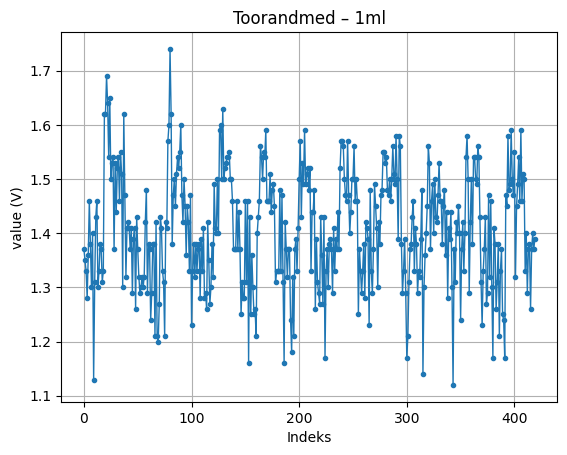

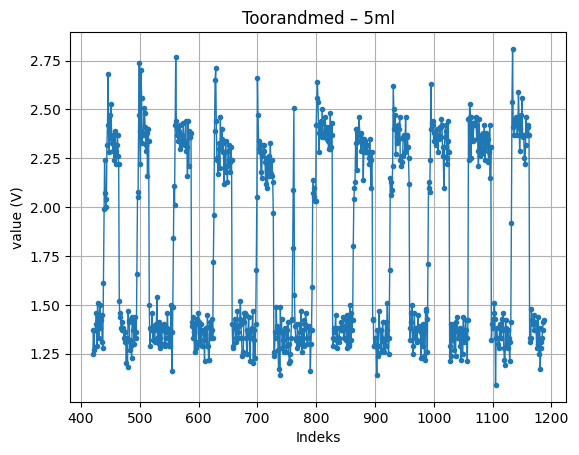

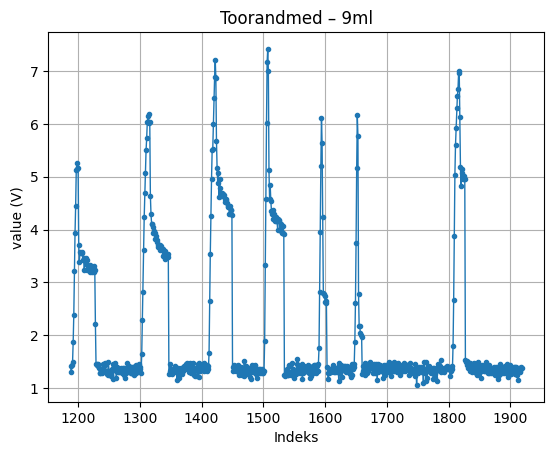

In [16]:
import matplotlib.pyplot as plt

for cat, sub in df.groupby("category"):
    plt.figure()
    plt.plot(sub.index, sub["value"], marker=".", linewidth=1)
    plt.xlabel("Indeks")
    plt.ylabel("value (V)")   # kui sul on pinge
    plt.title(f"Toorandmed – {cat}")
    plt.grid(True)
    plt.show()


In [9]:
SENSOR_SUPPLY_V = 5.0    # Vs
SENSOR_OFFSET   = 0.04   # Vout/Vs null-nihke koef.
SENSOR_SENS     = 0.001285  # per kPa

def vout_to_pa(v):
    p_kpa = ((v / SENSOR_SUPPLY_V) - SENSOR_OFFSET) / SENSOR_SENS
    return 1000.0 * p_kpa  # Pa

# Kui 'value' on Vout voltides:
df["pressure_Pa"] = df["value"].apply(vout_to_pa)

# Kui 'value' on juba Pa, kasuta seda:
# df["pressure_Pa"] = df["value"]

df[["category","value","pressure_Pa"]].head()

,category,value,pressure_Pa
0,1ml,1.37,182101.167315
1,1ml,1.35,178988.326848
2,1ml,1.33,175875.486381
3,1ml,1.28,168093.385214
4,1ml,1.36,180544.747082


In [4]:
# Müra (std) kategooriate sees
noise_tbl = df.groupby("category")["pressure_Pa"].agg(["mean","std"]).rename(columns={"std":"noise_Pa"})
display(noise_tbl)

FSR_PA = 700_000.0   # MPX5700 ulatus Pa-s
noise_rms_pa = float(noise_tbl["noise_Pa"].max())  # konservatiivne (võta halvim)
min_res_pa = 6.0 * noise_rms_pa                     # efektiivne eristatav samm (~6·σ)

# ENOB hinnang: ENOB ~ log2(FSR / (sqrt(12) * Noise_RMS))
import numpy as np
ENOB = np.log2(FSR_PA / (np.sqrt(12.0) * noise_rms_pa)) if noise_rms_pa > 0 else float("nan")

print(f"Efektiivne resolutsioon ≈ {min_res_pa:.1f} Pa (≈ 6·σ)")
print(f"Hinnanguline ENOB: {ENOB:.2f} bitti")
print("Diapason (ulatus): 0 … 700 000 Pa (MPX5700AP nimivahemik)")

,mean,noise_Pa
category,,
high_9ml,298276.972539,220289.818979
low_1ml,187919.214378,16533.122075
mid_5ml,247880.188067,76796.792290


Efektiivne resolutsioon ≈ 1321738.9 Pa (≈ 6·σ)
Hinnanguline ENOB: -0.12 bitti
Diapason (ulatus): 0 … 700 000 Pa (MPX5700AP nimivahemik)
